# Task 01: Selecting earthquakes
* Earthquake events downloaded from the USGS earthquake catalog (https://earthquake.usgs.gov/earthquakes/search/) for the study area (-123 to -125.5 degrees West and 37.5 to 41.5 degrees North), from January 1, 1970 to September 1, 2023 and magnitude 2.0 and above. 
* Subduction interface (between undergoing Juan de Fuca/Gorda plate and overriding North American plate) data called `slab2` is downloded from https://www.sciencebase.gov/catalog/item/5aa312cde4b0b1c392ea3ef5 
* The following codes will select earthquakes that are avobe the interface (i.e., earthquake depth < interface depth) and earthquakes that are within the area covered by the slab2 data (slab2 data is for limited area).
* It will also select earthquakes after January 1, 2008 to Jan 01, 2023

# Part 1: Data selection and preparation

In [40]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygmt

eq_data_dir = f"{os.getcwd()}/../data/eq_data"
cat_folder = f"{eq_data_dir}/1_eq_catalogs/"        # usgs catalog and slab2 data folder
fault_data_dir = f"../data/USGS-Fault/Q_fault"      # usgs fault data folder
topo_data = f"./Mapping/GMRTv4_2_122-128w_39-42.grd"
aboveslab_eq_file = f'{cat_folder}/usgs_3D_gridsort_eq_above_slab2_area.csv'   # eqs above slab2

aboveslab_eq_df = pd.read_csv(f'{cat_folder}/usgs_3D_gridsort_eq_above_slab2_area.csv', parse_dates=["time"])
# selected_eqs = pd.read_csv(selected_eq_file) 


# (1) Select desired events from the catalog. To get a good spatial distribution I divided the study area into grids of 0.2 degrees.
Now, I select the highest magnitude events from each grid.
Also check if the depth is `artificial` i.e, a given value of 5, 10, 15 or 20 km when depth constrain is bad.

In [41]:

eqdf = aboveslab_eq_df[aboveslab_eq_df.mag >= 2.5].reset_index(drop=True)

In [46]:
# Extract unique grid codes and sort them
unique_grid_codes = np.sort(eqdf['grid_3D_coarse'].unique())
print(f"Number grids with eq : {len(unique_grid_codes)}")

# create an empty dataframe to store the selected events
selected_eq = pd.DataFrame(columns=eqdf.columns)

# group the eqs by grid code of choice ############################
grouped_eq = eqdf.groupby('grid_3D_coarse')

# select `n` number of events from each grid
n = 50
for grid_code in unique_grid_codes:
    grid_eq = grouped_eq.get_group(grid_code)
    if grid_eq.empty:
        continue

    if len(grid_eq) > n: # select n number of events from each grid
        selected_eq = pd.concat([selected_eq, grid_eq.head(n)], ignore_index=True)

    else:              # select all events if less than n
        selected_eq = pd.concat([selected_eq, grid_eq], ignore_index=True)
        nevents = len(grid_eq)


# save the selected events
selected_eq_file = f"{cat_folder}/selected_eq_coarse3D{len(selected_eq)}.csv"
selected_eq.to_csv(selected_eq_file, index=False)
print(f"Number of selected events : {len(selected_eq)}")
print(selected_eq_file)

Number grids with eq : 23
Number of selected events : 244
/Users/mdarifulislam/Library/CloudStorage/OneDrive-IndianaUniversity/Research/Github/FM2STRESS/FM2STRESS_project/code/../data/eq_data/1_eq_catalogs//selected_eq_coarse3D244.csv


/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_38659/357340791.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_eq = pd.concat([selected_eq, grid_eq], ignore_index=True)


# Plot 3D gridded earthquaks using PyGMT

### Load the regional Faults into a dictionary

In [43]:
# get list of fault file names
fault_files = os.listdir(fault_data_dir)
fault_files.sort()

usgs_fault_dir = f"../data/USGS-Fault"
mtj_faults = []
# get all filepaths in the directory and subdirectories 
for root, dirs, files in os.walk(usgs_fault_dir):
    for file in files:
        if file.endswith(".txt"):
            mtj_faults.append(os.path.join(root, file))

mtj_faults.sort()        

# read the fault data
faults_dict_np = {}
for fault_file in mtj_faults:
    fault_name = fault_file.split('/')[-1].split('.')[0]
    faults_dict_np[fault_name] = np.loadtxt(fault_file, delimiter=' ',) # read & store the fault data in the dict

plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 21 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data a

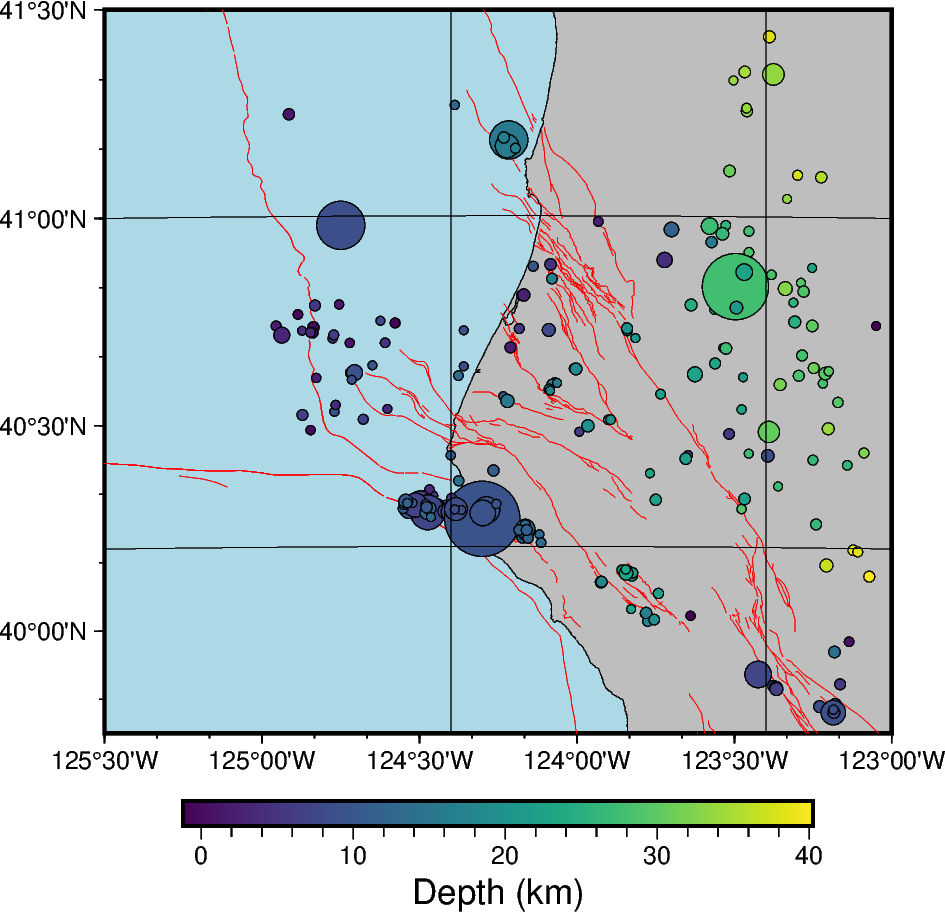

In [47]:
eqs_to_plot = selected_eq
region = [-125.5, -123, 39.75, 41.5]

# Create a PyGMT figure
fig = pygmt.Figure()

with pygmt.config(MAP_FRAME_TYPE="plain"):
    # add coastlines
    fig.coast(region=region, projection="M10c", frame=True, land="gray", water="lightblue", shorelines=True)

# plot faultline
for i, fault_name in enumerate(faults_dict_np.keys()):
    fig.plot(
        x=faults_dict_np[fault_name][:,0], # 1st column is longitude
        y=faults_dict_np[fault_name][:, 1], # 2nd column is latitude 
        pen='.1p,red',
        # label=fault_name,
    )

pygmt.makecpt(cmap="viridis", series=[eqs_to_plot.depth.min(), eqs_to_plot.depth.max()])
# plot grid earthquakes
fig.plot(
    x=eqs_to_plot['longitude'],
    y=eqs_to_plot['latitude'],
    size= 0.02 * (2 ** eqs_to_plot.mag),
    fill=eqs_to_plot['depth'],
    cmap=True,
    style='cc',
    pen='black',
)

fig.colorbar(frame="xaf+lDepth (km)")

# draw grid lines
xgrids = np.array([-124.4, -123.4])
ygrids = np.array([40.2, 41])
for x in xgrids:
    fig.plot(x=[x, x], y=[39.75, 41.5], pen='0.2p,black')
for y in ygrids:
    fig.plot(x=[-125.5, -123], y=[y, y], pen='0.2p,black')


fig.show(dpi=200, width=800)

# Make a shaded topo map with earthquakes

plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 21 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data a

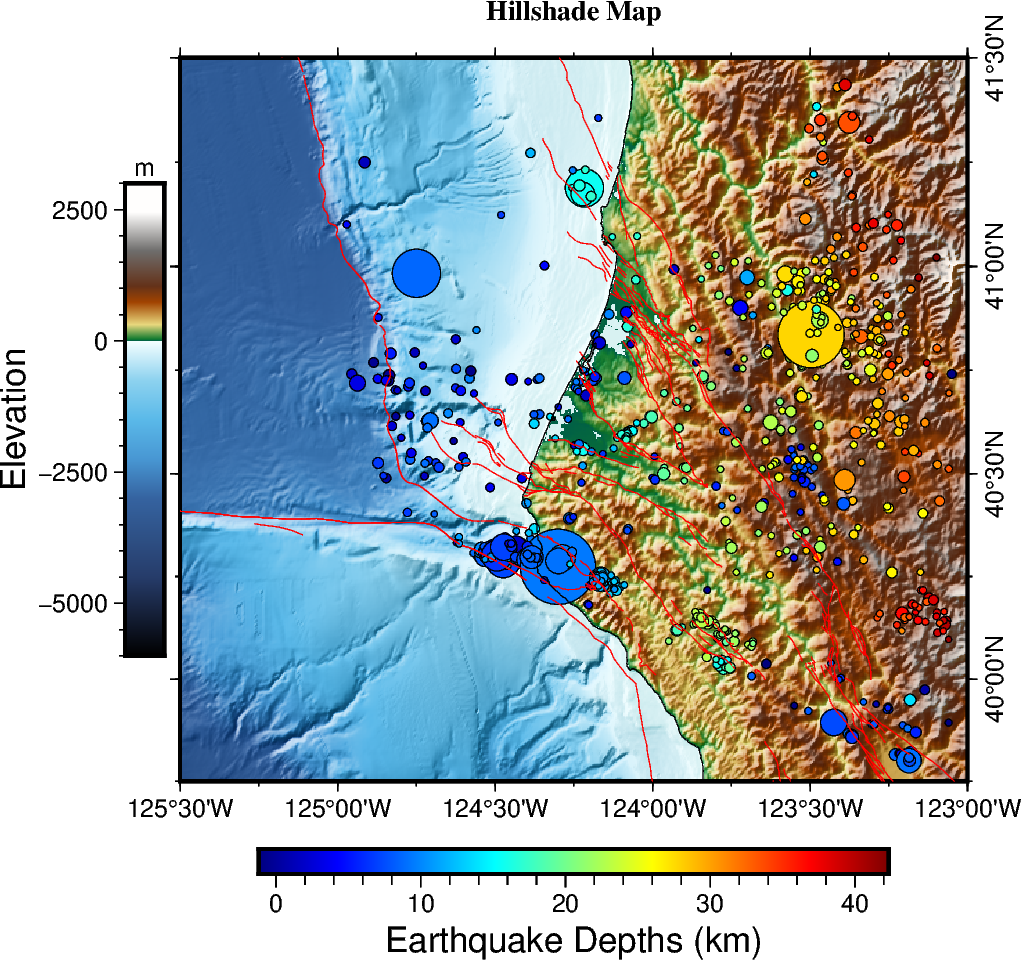

In [48]:
# region=[-128, -122, 39, 42]
region = [-125.5, -123, 39.75, 41.5]

proj="M10c"
azi="0/90"
nor="e1" # normalize the intensity

fig = pygmt.Figure()

# Define color palette
pygmt.makecpt(cmap="geo", series=[-6000, 3000])

# Define figure configuration
with pygmt.config(
    FONT_TITLE="10p,5",
    MAP_TITLE_OFFSET="1p",
    MAP_FRAME_TYPE="plain",
    MAP_ANNOT_OBLIQUE="lat_parallel"
    ):

    # Making an intensity DataArray using azimuth and normalize parameters
    shade = pygmt.grdgradient(grid=topo_data, azimuth=azi, normalize=nor)

    # Plot the topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection=proj,
        shading=True,
        frame=['SEnw', "xa0.5f0.25", "ya0.5f0.25"], # +tHillshade Map
        cmap=True,
        
        )
        
    # add colorbar
    fig.colorbar(
        position="JML+o0.2c/0c+w6c/0.5c", # +o: offset, +w: width
        # position="x-0.75c/0.75c+w5c/0.5c+m+v+e", # +m: text position, +v: vertical, +e: triangles outside
        frame=["a2500f500+lElevation", "y+lm"]
        )
    
        
# make a color palette
pygmt.makecpt(cmap="jet", series=[aboveslab_eq_df.depth.min(), aboveslab_eq_df.depth.max()])

# plot the selected earthquakes with bigger size [proporional to magnitude]
fig.plot(
    x=aboveslab_eq_df['longitude'],
    y=aboveslab_eq_df['latitude'],
    size=0.02 * (2 ** aboveslab_eq_df.mag),
    fill=aboveslab_eq_df.depth,
    cmap=True,
    style="cc",
    pen="black",
    # label="Selected Earthquakes",
    )
# add colorbar for earthquake depths
fig.colorbar(frame="xaf+lEarthquake Depths (km)")

# # add legend for the earthquake magnitudes 2-7 [6 circles with different sizes] # show only 3 circles
# fig.plot(
#     x=np.array([-125.5, -125.5, -125.5, -125.5, -125.5, -125.5])-2.1,
#     y=np.array([40.5, 40.55, 40.65, 40.8, 41.1, 41.6])-1.4,
#     size=0.1 * (2 ** np.arange(2, 8)),
#     style="cc",
#     fill="white",
#     pen="black",
#     # label="Magnitude 2-7",
#     )

# # add a box to show the selected area
# fig.plot(
#     x=[-125.5, -123, -123, -125.5, ],
#     y=[39.75, 39.75, 41.5, 41.5, ],
#     pen="0.5p,black",
#     close=True,
#     label="Selected Area",
#     )

# plot faultline
for i, fault_name in enumerate(faults_dict_np.keys()):
    fig.plot(
        x=faults_dict_np[fault_name][:,0], # 1st column is longitude
        y=faults_dict_np[fault_name][:, 1], # 2nd column is latitude 
        pen='.25p,red',
        # label=fault_name,
    )

# add coastlines
fig.coast(region=region, projection=proj, shorelines=True)

# limit the map to the selected area

fig.show(dpi=200, width=1000)